# EDA

In our exploratory data analysis, we will look at the following aspects of the dataset:

1. Network structure: Looking at pages with highest in-degree and out-degrees and the distributions.
2. Connectivity and centrality: Looking at the centrality measures of the pages.
3. Time series analysis: Looking at pages visits over time to find any trends or patterns.

**Note: Terms and metrics**

* In-degree: The number of incoming links to a page.
* Out-degree: The number of outgoing links from a page.
* Betweenness centrality: The number of shortest paths that pass through a node.
* Eigenvector centrality: A measure of the influence of a node in a network.
* Closeness centrality: A measure of how close a node is to all other nodes in a network.
* Clustering coefficient: A measure of the degree to which nodes in a graph cluster together.

In [24]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import networkx as nx
from main import get_data

In [3]:
# Load data
#with open("wikivital_mathematics.json") as f:
#    data = json.load(f)
data = get_data()

In [4]:
# Print 10 of the keys 
keys = list(data.keys())
print(keys[:10])

['edges', 'weights', 'node_ids', 'time_periods', '0', '1', '2', '3', '4', '5']


In [5]:
# Print 10 node_ids (page name and ID) in ascending order
sorted_node_ids = sorted(data['node_ids'].items(), key=lambda x: x[1])
for i in range(10):
    print(sorted_node_ids[i])

('Mathematics', 0)
('Number theory', 1)
('Algebra', 2)
('Geometry', 3)
('Calculus', 4)
('Mathematical analysis', 5)
('Conjecture', 6)
('Mathematical proof', 7)
('Counting', 8)
('Shape', 9)


The dataset contains information about the number of visits to 1068 pages of the English Wikipedia, as well as the relationships between them. The data is divided into 731 time periods, each of which contains the number of visits to each page on a given day. The dataset also contains information about the relationships between the pages, which are represented as a graph. 

The dataset is stored in a dictionary with the following keys:

* `edges`: a list of pairs (lists) that show links between pages. For example, [0, 1] indicates that there is a link from "Mathematics" (has an ID of 0) to "Number theory" (has an ID of 1)
* `weight`: a list of integers that show the number of times a page appears in another. For example, if the weight of the link from "Mathematics" to "Number theory" is 3, the "Mathematics" Wiki page has 3 links to the "Number theory" page. 
* `time_periods`: the number of time periods considered in the dataset (data was collected over a span of 731 days).
* `node_ids`: maps the ID of a page to its name. For example, `"Mathematics" 0` means the "Mathematics" page uses the ID 0.
* `0`, `1`, ..., `730`: daily visits data for each of the 731 days that the data was collected. Each has a dictionary with the following keys:
  * `year`: the year of data collection
  * `month`: the month of data collection
  * `day`: the day of data collection
  * `y`: the page's visit counts for each of the 1068 `node_ids`. For example, `"y":[100, 20, ...]` means that the "Mathematics" page (with ID 0) had 100 visits on that day, the second page (with ID 1) had 20 visits, etc.

In [6]:
# Extract keys for closer analysis
edges = data['edges']
node_ids = data['node_ids']
weights = data['weights']

In [7]:
# How many edges there are
len(edges)

27079

There are 27,079 edges, which tells us that there are 27,079 links between the 1,068 pages. The average number of outgoing links per page is 25.36, which means that each page has an average of 25.36 links to other pages. 

# 1. Network Structure

## In-Degrees and Out-Degrees

Which pages have the most outgoing links (out-degrees)? Which pages have the most incoming links (in-degrees)? In other words, which pages serve as major sources of information and which pages are key destinations?



In [8]:
# Counts of out-degrees and in-degrees
out_degrees = Counter(edge[0] for edge in edges)
in_degrees = Counter(edge[1] for edge in edges)

print('Most common out-degrees: ', out_degrees.most_common(10))
print('Most common in-degrees: ', in_degrees.most_common(10))

Most common out-degrees:  [(0, 533), (62, 290), (70, 270), (64, 214), (56, 201), (3, 198), (4, 197), (45, 197), (63, 186), (5, 184)]
Most common in-degrees:  [(510, 101), (796, 99), (600, 89), (780, 89), (302, 82), (400, 82), (312, 80), (313, 80), (311, 79), (482, 79)]


This isn't very helpful without the page names, so we'll also need to map the page IDs to their names.

In [9]:
# Get node_ids in the format {ID: page name} instead of {page name: ID}
id_to_name = {v: k for k, v in node_ids.items()}

# Convert node IDs in the degree counts to page names
out_degrees_with_names = {id_to_name[node_id]: count for node_id, count in out_degrees.items()}
in_degrees_with_names = {id_to_name[node_id]: count for node_id, count in in_degrees.items()}

# Pages with most DISTINCT links leading to other pages (out-degree) and
# pages with most other DISTINCT pages linking to them links (in-degrees)
print("Pages with highest unweighted out-degrees:")
for page, degree in Counter(out_degrees_with_names).most_common(10):
    print('\t', page, ': ', degree)

print("\nPages with highest unweighted in-degrees:")
for page, degree in Counter(in_degrees_with_names).most_common(10):
    print('\t', page, ': ', degree)

Pages with highest unweighted out-degrees:
	 Mathematics :  533
	 Real number :  290
	 Function (mathematics) :  270
	 Complex number :  214
	 Integer :  201
	 Geometry :  198
	 Calculus :  197
	 Set (mathematics) :  197
	 Continuous function :  186
	 Mathematical analysis :  184

Pages with highest unweighted in-degrees:
	 Logarithm :  101
	 Eigenvalues and eigenvectors :  99
	 Bijection :  89
	 Laplace transform :  89
	 Factorial :  82
	 Domain of a function :  82
	 Exponential function :  80
	 Natural logarithm :  80
	 Differential form :  79
	 Exponentiation :  79


The **out-degree** list consists of very broad and fundamental math topics. These probably serve as overview pages that guide people to more specific topics. These pages would probably be good starting points for people to learn about a math topic becasue they give you many pathways to explore further.

The **in-degree** list consists of more specific topics. These are probably concepts that are foundational or critical enough that many other pages build upon them or require an understanding of them. They are like prerequisites for other topics.

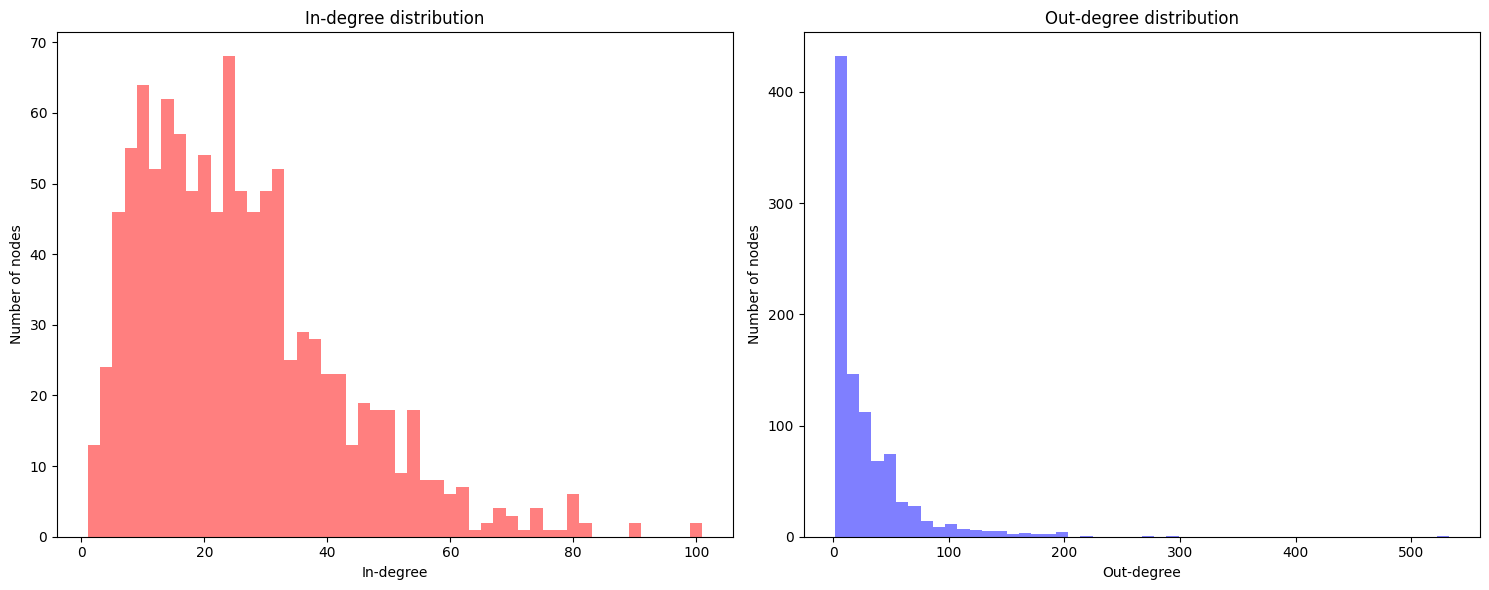

In [169]:
# Histograms of in- and out-degree distributions
in_degree_values = list(in_degrees.values())
out_degree_values = list(out_degrees.values())

fig, ax = plt.subplots(1, 2, figsize=(15, 6))
# In degree dist
ax[0].hist(in_degree_values, bins=50, color='red', alpha=0.5, label='In-degrees')
ax[0].set_xlabel('In-degree')
ax[0].set_ylabel('Number of nodes')
ax[0].set_title('In-degree distribution')
# Out degree dist
ax[1].hist(out_degree_values, bins=50, color='blue', alpha=0.5, label='Out-degrees')
ax[1].set_xlabel('Out-degree')
ax[1].set_ylabel('Number of nodes')
ax[1].set_title('Out-degree distribution')
plt.tight_layout()
plt.show()

The in-degree distribution is right-skewed and tells us that most pages have a low number of incoming links and a few pages that have a high number of incoming links. This suggests that there are a few key pages that are central to the network and receive a large number of incoming links. These are likely key topics in mathematics and might be the pages that we find rank highly in PageRank since many other pages link to them, indicating they are important to the structure of the network. 

In the out-degree distribution, we can see that the distribution is extremely skewed, with a large number of pages having no or very few outgoing links and a very small number of pages having a high number of outgoing links. These are likely the broad overview pages that serve as starting points for exploring more specific topics and link out to many subtopics.

## Weighted In-Degrees and Out-Degrees

**The unweighted in- and out-degrees tell us the number of DISTINCT links to and from a page.** So, if the out-degrees of page 0 is 500, that means there are 500 links on page 0 that go to 500 different pages. It does NOT tell us how many times it links to each one though; it just simply counts the presence of a connection.

**The weights tell us the TOTAL number of links. It includes multiple links to the same page.** So, if the weighted out-degree of page 0 is 600, that means there are 600 TOTAL links on page 0 (that could mean it links to one page 600 times, or 600 different pages once, or some combination of the two).

In [10]:
# Initialize counters for weighted degrees
weighted_out_degrees = defaultdict(float)
weighted_in_degrees = defaultdict(float)

# Sum up weights for in-degrees and out-degrees
'''
E.g., 
in `edges` we have [0,1], [0,2], [0,3]
in `weights` we have 1, 4, 2

weighted out-degrees: all edges start from 0 so we sum all weights for outgoing links
    so weighted out-degree for 0 = 1+4+2 = 7

weighted in-degrees: 
    weighted out-degree for 1 = 1 (1 link from ID0)
    weighted out-degree for 2 = 4 (4 links from ID0)
    weighted out-degree for 3 = 2 (2 links from ID0)
'''
for (page_a, page_b), weight in zip(edges, weights):
    weighted_out_degrees[page_a] += weight
    weighted_in_degrees[page_b] += weight

# Convert node_ids to page names instead of IDs
weighted_out_degrees_with_names = {id_to_name[node_id]: weight for node_id, weight in weighted_out_degrees.items()}
weighted_in_degrees_with_names = {id_to_name[node_id]: weight for node_id, weight in weighted_in_degrees.items()}

# Top weighted in- and out-degrees
print("Pages with highest weighted out-degrees:")
for page, weight in sorted(weighted_out_degrees_with_names.items(), key=lambda item: item[1], reverse=True)[:10]:
    print('\t', page, ': ', weight)

print("\nPages with highest weighted in-degrees:")
for page, weight in sorted(weighted_in_degrees_with_names.items(), key=lambda item: item[1], reverse=True)[:10]:
    print('\t', page, ': ', weight)


Pages with highest weighted out-degrees:
	 Mathematics :  654.0
	 Real number :  470.0
	 Function (mathematics) :  392.0
	 Set (mathematics) :  367.0
	 Continuous function :  330.0
	 Complex number :  324.0
	 Calculus :  314.0
	 Integer :  308.0
	 Vector space :  290.0
	 Field (mathematics) :  280.0

Pages with highest weighted in-degrees:
	 Logarithm :  143.0
	 Bijection :  131.0
	 Eigenvalues and eigenvectors :  128.0
	 Exponentiation :  121.0
	 Euclidean space :  117.0
	 Number :  115.0
	 Line integral :  115.0
	 Function of several real variables :  115.0
	 Partial derivative :  113.0
	 General topology :  113.0


When we look at the top 10 pages with the highest weighted out-degrees, we don't see a major change compared to the unweighted out-degrees. This list still consists of very broad and fundamental math topics.

However, we see more of a change in the weighted in-degrees compared to the unweighted ones. Outside of the top 3 in this list, the rest of the list is different.

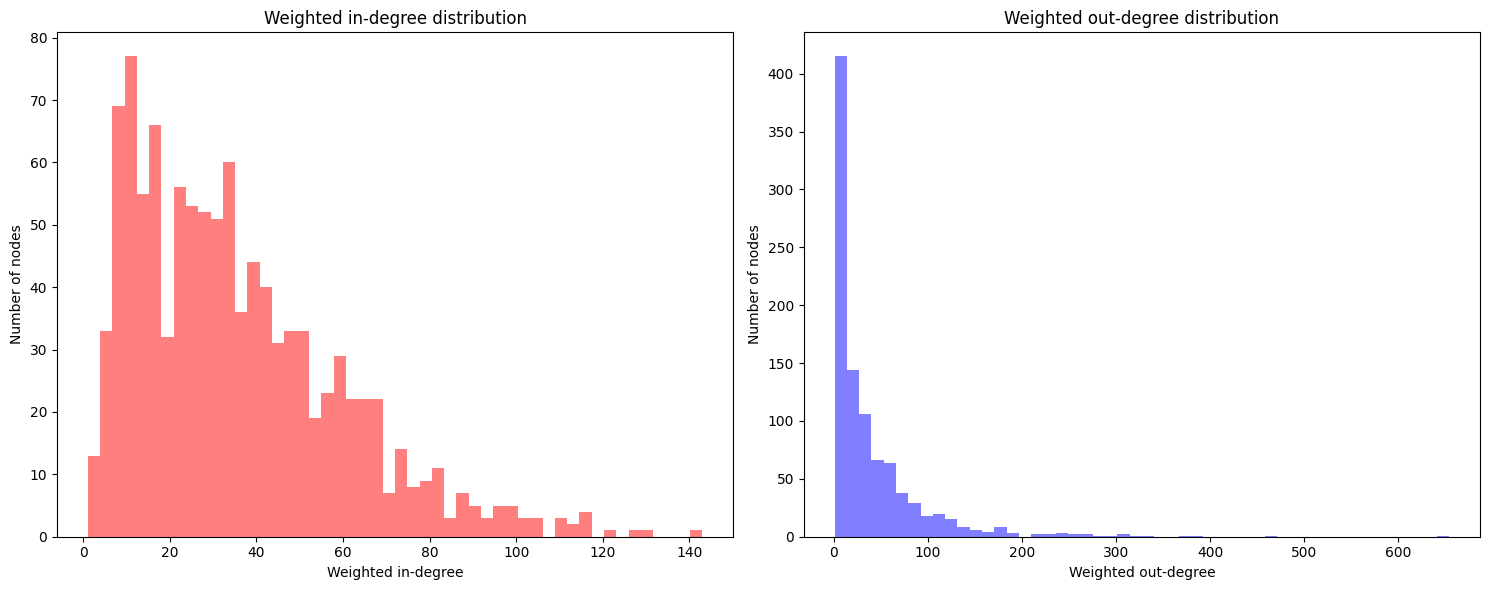

In [170]:
# Histograms of in- and out-degree distributions
weighted_in_degree_values = list(weighted_in_degrees.values())
weighted_out_degree_values = list(weighted_out_degrees.values())

fig, ax = plt.subplots(1, 2, figsize=(15, 6))
# In degree dist
ax[0].hist(weighted_in_degree_values, bins=50, color='red', alpha=0.5, label='In-degrees')
ax[0].set_xlabel('Weighted in-degree')
ax[0].set_ylabel('Number of nodes')
ax[0].set_title('Weighted in-degree distribution')
# Out degree dist
ax[1].hist(weighted_out_degree_values, bins=50, color='blue', alpha=0.5, label='Out-degrees')
ax[1].set_xlabel('Weighted out-degree')
ax[1].set_ylabel('Number of nodes')
ax[1].set_title('Weighted out-degree distribution')
plt.tight_layout()
plt.show()

The weighted degree distributions are also right-skewed, which tells us that there are a few pages that have a high number of incoming and outgoing links, while most pages have a low number of links. This is similar to the unweighted degree distributions, but the weighted distributions give us a more accurate picture of the importance of a page in the network because they take into account the number of times a page links to another page.

## Weight Analysis

* The weight of a link is the number of times a page links to another page.

Min weight: 1
Max weight: 16
Average weight: 1.3993500498541305
Median weight: 1.0


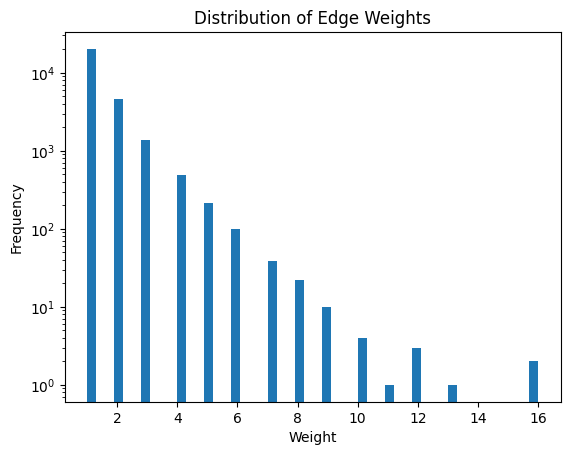

In [11]:
# Summary statistics
print("Min weight:", min(weights))
print("Max weight:", max(weights))
print("Average weight:", np.mean(weights))
print("Median weight:", np.median(weights))

# Plot weight distribution
plt.hist(weights, bins=50, log=True)  # log scale for better visibility
plt.title('Distribution of Edge Weights')
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.show()


In [12]:
# Page connections with highest weights
# (has most links in them leading to other pages)

# Combine edges and weights 
edges_with_weights = list(zip(edges, weights))

# Sort the pairs by weight
edges_with_weights_sorted = sorted(edges_with_weights, key=lambda x: x[1], reverse=True)
#edges_with_weights_sorted

# Convert page IDs to page names (using `id_to_name` above)
edges_with_names_and_weights = [(id_to_name[edge[0][0]], id_to_name[edge[0][1]], edge[1]) for edge in edges_with_weights_sorted]
#edges_with_names_and_weights

# Print top connections by weight
print('Page connections with most links:')
for a, b, weight in edges_with_names_and_weights[:10]:
    print('\t', a, ' -> ', b, ': ', weight)

Page connections with most links:
	 Tetrahedron  ->  Octahedron :  16
	 Tetrahedron  ->  5-cell :  16
	 Continuous function  ->  Taylor's theorem :  13
	 Field (mathematics)  ->  Ring (mathematics) :  12
	 Topological space  ->  General topology :  12
	 Octahedron  ->  24-cell :  12
	 Tetrahedron  ->  Regular icosahedron :  11
	 Theoretical computer science  ->  Algorithm :  10
	 Cube  ->  Octahedron :  10
	 Equilateral triangle  ->  Hexagon :  10


# 2. Connectivity and Centrality

## Betweenness Centrality

This will tell us which pages are most important in connecting other pages.

The pages with high betweenness centrality scores are the pages that are most important in connecting other pages. These pages are like bridges that connect different parts of the network. If these pages were removed, it would be harder for information to flow between different parts of the network.

A page with a high betweenness centrality score is one that is often on the shortest path between other pages. This means that if you were to pick two random pages in the network, there is a high chance that the shortest path between them would pass through this page.
* That makes these very important (but only in terms of connecting other pages, not necessarily overall importance).

In [13]:
# Make a graph
G = nx.DiGraph()

'''
If using an UNWEIGHTED graph:

    If the number of links on page `a` that goes to `b` is not important,
    all connections are treated equally.
'''
# # UNWEIGHTED graph - add edges only
# G.add_edges_from(edges)
# # Compute betweenness for UNWEIGHTED graph:
# betweenness = nx.betweenness_centrality(G, weight='weight')

'''
If using a WEIGHTED graph:

    If the number of links on page `a` that goes to `b` is important.
    Paths with less links as "shorter" or "easier" to traverse
'''
# WEIGHTED graph - add edges and weights
for edge, weight in zip(edges, weights):
    G.add_edge(edge[0], edge[1], weight=weight)


In [14]:
# Compute betweenness for WEIGHTED graph
betweenness = nx.betweenness_centrality(G, weight='weight')

# Sort the scores
sorted_betweenness = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)

# Convert node IDs to page names
betweenness_with_names = [(id_to_name[node_id], count) for node_id , count in sorted_betweenness]

print('Pages with highest betweenness centrality:')
for page, score in betweenness_with_names[:10]:
    print('\t', page, 'page: ', score)

Pages with highest betweenness centrality:
	 Bijection page:  0.01151381639131695
	 Logarithm page:  0.011031123144553736
	 Domain of a function page:  0.008993257405928433
	 Directed graph page:  0.007727973612588293
	 Total order page:  0.006882752546486764
	 Exponentiation page:  0.0068402192163225664
	 Big O notation page:  0.006084508264464584
	 Factorial page:  0.005971530872977287
	 Absolute value page:  0.005788469166841349
	 Cartesian product page:  0.005520265858572751


These are the topics that are crucial in understanding because they link different areas of math. 

## Closeness Centrality

This will tell us which pages are closest to all other pages in the network.

In [15]:
# Compute closeness for WEIGHTED graph
closeness = nx.closeness_centrality(G, distance='weight')

# Sort the scores
sorted_closeness = sorted(closeness.items(), key=lambda x: x[1], reverse=True)

# Convert node IDs to page names
closeness_with_names = [(id_to_name[node_id], count) for node_id , count in sorted_closeness]

print('Pages with highest closeness centrality:')
for page, score in closeness_with_names[:10]:
    print('\t', page, 'page: ', score)

Pages with highest closeness centrality:
	 Surjective function page:  0.25842005496307235
	 Graph homomorphism page:  0.25786837721391487
	 Constant function page:  0.25012985901893803
	 Preorder page:  0.2458037087813985
	 Bipartite graph page:  0.24273708687733198
	 Component (graph theory) page:  0.24170663306050902
	 Cycle (graph theory) page:  0.23878499092143857
	 Hypergraph page:  0.23774802784309546
	 Lambert W function page:  0.2375673805441571
	 Stirling numbers of the second kind page:  0.23514255888730043


## Eigenvector Centrality

This will tell us which pages are most influential in the network.

In [16]:
eigenvector_centrality = nx.eigenvector_centrality(G, weight='weight', max_iter=1000)

# Sort the scores
sorted_ev = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)

# Convert node IDs to page names
ev_centrality_with_names = [(id_to_name[node_id], count) for node_id , count in sorted_ev]

print('Pages with highest Eigenvector centrality:')
for page, score in ev_centrality_with_names[:10]:
    print('\t', page, 'page: ', score)

Pages with highest Eigenvector centrality:
	 Rotations in 4-dimensional Euclidean space page:  0.8896601493885045
	 24-cell page:  0.45162199606253056
	 120-cell page:  0.06702947471207041
	 600-cell page:  0.005427733362065099
	 Coxeter graph page:  0.003128100362879948
	 Tait's conjecture page:  0.0024483290039999718
	 Lovász conjecture page:  0.0016317152017032086
	 Herschel graph page:  0.0008514918086355966
	 5-cell page:  0.0006480343673580404
	 Hamiltonian path page:  0.0004237845094678468


This tells us which pages are most influential within the network of math topics. 

The pages with high eigenvector centrality scores are the pages that are well-connected and connected to other well-connected pages.
* Key nodes through which many paths pass through. 

"Rotations in 4-dimensional Euclidean space" is most influential by far. Then there is a significant drop in "24-cell" and an even bigger drop to the other pages.

The topics are predominantly about geometry and graph theory. 
* They're crucial hubs in the math network.

# 3. Time Series Analysis

Analyzing the daily visits to the pages over the time periods to vizualize trends and patterns in page visits over time and identify any seasonality, spikes, or anomalies in visit counts. 

In [70]:
time_periods = {}
for time_period in range(data['time_periods']):
    time_periods[time_period] = data[str(time_period)]
dates = pd.DataFrame.from_dict(time_periods, orient="index", columns=['year', 'month', 'day'])

#  Find daily visitation of each page
daily_visits = pd.DataFrame.from_dict(time_periods, orient="index", columns=['y'])
daily_visits = pd.DataFrame(daily_visits.y.to_list()) 
daily_visits = daily_visits.set_index(pd.to_datetime(dates))
# Convert page IDs to page names
daily_visits.columns = [id_to_name[page] for page in daily_visits.columns]

In [71]:
daily_visits.head()

,Mathematics,Number theory,Algebra,Geometry,Calculus,Mathematical analysis,Conjecture,Mathematical proof,Counting,Shape,...,Component (graph theory),Minimum-cost flow problem,Stable roommates problem,Blossom algorithm,Tutte–Berge formula,Herschel graph,Tait's conjecture,Multibody system,Dynamic simulation,Cache replacement policies
2019-03-16,3962,774,1734,1016,2463,436,214,402,363,490,...,0,56,66,38,1,11,5,36,20,364
2019-03-17,3923,772,1884,1301,2365,497,163,470,342,508,...,18,74,60,53,5,7,10,37,26,334
2019-03-18,4617,827,2059,1251,2801,593,255,562,519,711,...,128,130,112,90,6,15,21,47,39,468
2019-03-19,4822,863,2041,1336,2935,530,279,576,474,842,...,132,129,101,78,9,6,14,73,39,487
2019-03-20,4871,906,2017,1379,2803,559,265,611,502,721,...,98,131,59,67,12,18,6,97,39,448


In [72]:
# find the total number of visits to each page 
# and the total number of visits on each day
total_visits_per_page = daily_visits.sum(axis=0)
total_visits_per_day = daily_visits.sum(axis=1)
total_visits_per_page

Mathematics                   3192685
Number theory                  613376
Algebra                       1361854
Geometry                       913110
Calculus                      1814357
                               ...   
Herschel graph                   7141
Tait's conjecture                5869
Multibody system                26525
Dynamic simulation              22126
Cache replacement policies     335957
Length: 1068, dtype: int64

In [73]:
total_visits_per_day

2019-03-16    531653
2019-03-17    593023
2019-03-18    800956
2019-03-19    824119
2019-03-20    809170
               ...  
2021-03-11    828284
2021-03-12    735302
2021-03-13    584380
2021-03-14    692399
2021-03-15    832575
Length: 731, dtype: int64

In [100]:
# Find 10 pages with the most total visits
top10_pages = total_visits_per_page.nlargest(10)
print('Top 10 pages with the most visits:')
for page, count in top10_pages.items():
    print('\t', page, ': ', count)

Top 10 pages with the most visits:
	 Normal distribution :  5355019
	 Standard deviation :  5131200
	 Fibonacci number :  4524975
	 Pi :  3742122
	 Roman numerals :  3730168
	 Prime number :  3368175
	 Poisson distribution :  3276035
	 Mathematics :  3192685
	 Golden ratio :  3038084
	 Taylor series :  2637277


In [99]:
# Find 10 days with the most total visits
top10_days = total_visits_per_day.nlargest(10)
print('Days with the most visits:')
for day, count in top10_days.items():
    print('\t', day.strftime('%Y-%m-%d'), ': ', count) # Modify dates to exclude timestamps

Days with the most visits:
	 2019-03-27 :  1323743
	 2019-06-13 :  1252949
	 2019-04-23 :  1229385
	 2019-03-26 :  1016868
	 2019-11-13 :  1004456
	 2019-11-12 :  985047
	 2020-03-31 :  969174
	 2020-10-08 :  904728
	 2020-10-13 :  904085
	 2020-10-20 :  900934


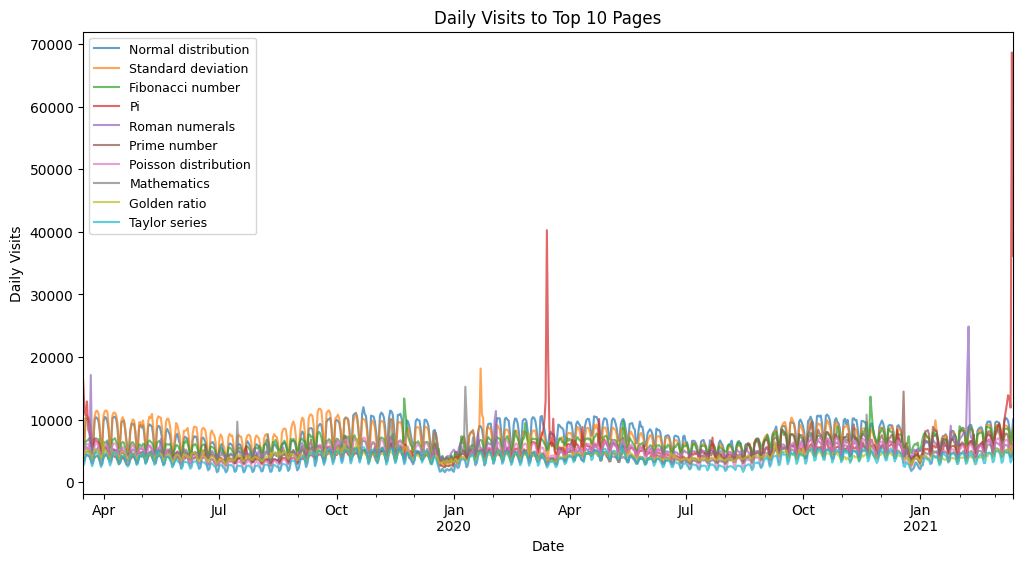

In [155]:
# Line plot of daily visits to top 10 pages using ax
ax = daily_visits[top10_pages.index].plot(figsize=(12, 6), alpha=0.7)
ax.set_title('Daily Visits to Top 10 Pages')
ax.set_xlabel('Date')
ax.set_ylabel('Daily Visits')
ax.legend(fontsize=9, loc='upper left')
plt.show()

From this plot, we find some interesting patterns:
* The page with the most visits overall (Normal distribution) is pretty consistent in its visits over time and does not have any large spikes or drops.
* The page with the second most visits overall (Standard deviation) has one spike in visits in late January 2020 and otherwise remains relatively consistent.
* The Pi wikipedia page has two very large spikes in visits that happen around the same time every year, which is Pi Day (March 14th). This is a very clear example of seasonality in the data.
* We also see a pretty large spike happen in the Roman numerals page in February 2021. My first thought was that this could be related to the Super Bowl, which uses roman numerals to number each game and happened on February 7th, 2021.

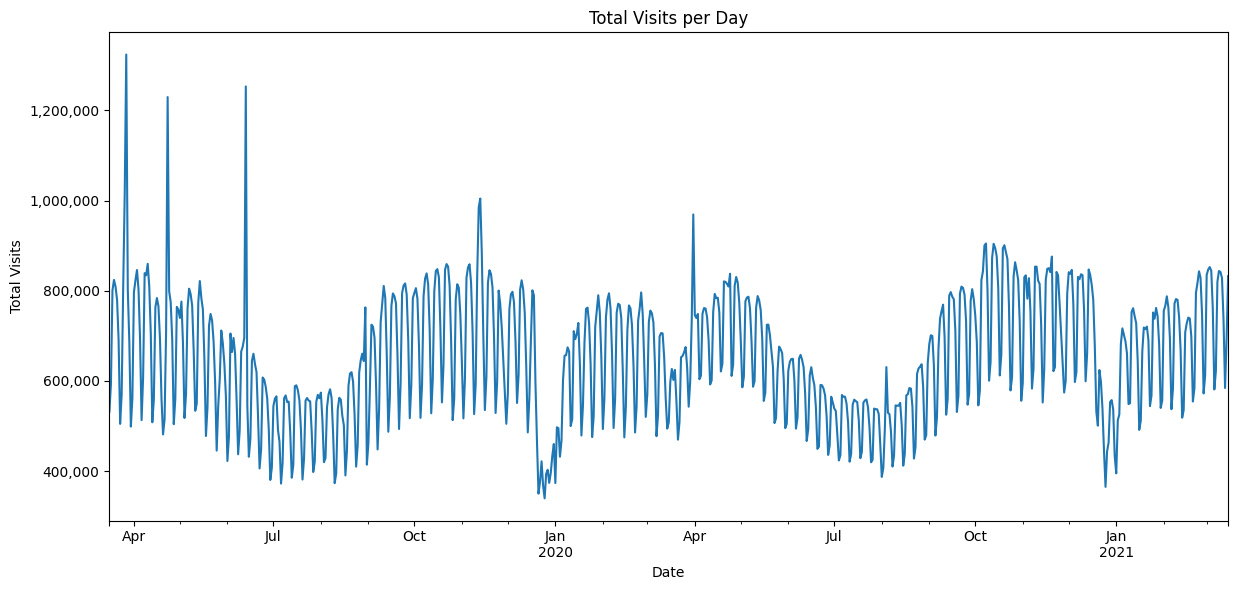

In [125]:
# Line plot of daily visits for top 10 pages
import matplotlib as mpl # For StrMethodFormatter to fix y-axis labels
ax = total_visits_per_day.plot(figsize=(12, 6))
ax.set_title('Total Visits per Day')
ax.set_xlabel('Date')
ax.set_ylabel('Total Visits')
plt.tight_layout()
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
#ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()]) # Works without mpl but gives a warning
plt.show()